# Music Generation with RNNs
Here,we will explore building a Recurrent Neural Network (RNN) for music generation. We will train model to learn the patterns in raw sheet music in ABC notation and then use this model to generate new music.

# Dependencies
Firstly,installing dependencies and import the relevant packages we'll need

In [5]:
# Import Tensorflow 2.0
import tensorflow as tf 

# Download and import the music21 package
import music21

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from music21 import *

# Dataset

We've gathered a dataset of thousands of Irish folk songs, represented in the ABC notation. Let's download the dataset and inspect it: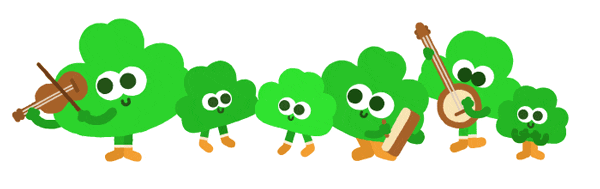

In [6]:
# Download the dataset

songs_obj = open("data.txt", "r")
songs_string =" "

for song_line in songs_obj:
#     print(song_line)
    songs_string += song_line

songs = songs_string.split("\n\n\n")
# Print one of the songs to inspect it in greater detail!
# example_song = songs[0]
print("\nExample song: ")
# print(songs)
print(songs[0])


Example song: 
 X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!

X:2
T:An Buachaill Dreoite
Z: id:dc-hornpipe-2
M:C|
L:1/8
K:G Major
GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!
DGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!
GA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!
B2BG c2cA|d^cde f2 (3def|g2gf gbag|fdcA G2:|!

X:3
T:Belfast
Z: id:dc-hornpipe-3
M:C|
L:1/8
K:D Major
ag|(3faf df AdFA|DFAd f2ef|gbec dfAF|GABG E2ag|!
(3faf df AdFA|DFAd f2ef|gbed cABc|d2f2 d2:|!
(3DEF|GFGA Bcde|fgfe dcdB|A2f2 fef2|G2e2 ede2|!
GFGA Bcde|fgfe dcdB|Afed cABc|d2f2 d2:|!
ag|(3fgf (3efe (3ded (3cdc|(3BcB (3ABA G2ba|(3gag (3fgf (3efe (3ded|(3cdc (3BcB A2ag|!
(3fgf (3efe (3ded (3cdc|(3BcB (3ABA (3GAG (3FGF|Eged cABc|d2f2 d2:|!

X:4
T:Blackbird
Z: id:dc-hornpipe-4
M:C|
L:1/8
K:D Mixolydian
AG|F2FA GFD2|de (3fed 

In [7]:
# Convert the ABC notation to audio file and listen to it
s = converter.parse(songs_string, number = 1)
s.show("midi")

It's very important to keep in mind that this notation of music also includes meta data, such as the song's title, key, and tempo, in addition to information about the notes being played. How does the complexity of the learning issue depend on the amount of different characters in the text file?This will become important soon, when we generate a numerical representation for the text data.

In [8]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs) 

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


# Process the dataset for the learning task
Let's take a step back and consider our prediction task. We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information.

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task.

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

# Vectorize the text
Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

In [9]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to len(unique). Let's take a peek at this numerical representation of our dataset:

In [10]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [11]:
### Vectorize the songs string ###

def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

vectorized_songs = vectorize_string(songs_joined)

We can also look at how the first part of the text is mapped to an integer representation:

In [12]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

' X:1\nT:Ale' ---- characters mapped to int ----> [ 1 49 22 13  0 45 22 26 67 60]


# Create training examples and targets
Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain seq_length characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of seq_length+1. Suppose seq_length is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [13]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  # input_batch = # TODO
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
  # output_batch = # TODO

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly! 
test_args = (vectorized_songs, 10, 2)

For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the RNN considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [14]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 32 ('G')
  expected output: 14 ('2')
Step   1
  input: 14 ('2')
  expected output: 26 ('A')
Step   2
  input: 26 ('A')
  expected output: 1 (' ')
Step   3
  input: 1 (' ')
  expected output: 27 ('B')
Step   4
  input: 27 ('B')
  expected output: 32 ('G')


# The Recurrent Neural Network (RNN) model
Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected Dense layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character.

As we introduced in the first portion of this lab, we'll be using the Keras API, specifically, tf.keras.Sequential, to define the model. Three layers are used to define the model:

* tf.keras.layers.Embedding: This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with embedding_dim dimensions.
* tf.keras.layers.LSTM: Our LSTM network, with size units=rnn_units.
* tf.keras.layers.Dense: The output layer, with vocab_size outputs.

# Define the RNN model
Now, we will define a function that we will use to actually build the model.

In [15]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [16]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    LSTM(rnn_units),
      
    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

# Test out the RNN model
It's always a good idea to run a few simple checks on our model to see that it behaves as expected.

First, we can use the Model.summary function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           21248     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


Checking the dimensionality of the output

In [18]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")


Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


# Predictions from the untrained model
Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a softmax over our character vocabulary. This will give us actual character indices. This means we are using a categorical distribution to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep.

Note here that we sample from this probability distribution, as opposed to simply taking the argmax, which can cause the model to get stuck in a loop.

Let's try this sampling out for the first example in the batch.

In [19]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([78, 76,  2, 27, 13, 73, 55, 25,  6, 74, 49, 78, 80, 40,  2, 39, 16,
       42, 27, 29, 32, 24, 15, 52, 40, 75, 44,  0,  6, 71, 63, 10, 73, 62,
       19, 77, 82,  7, 51, 72,  5, 69,  8, 80, 52, 41,  0,  5, 11, 16, 80,
       24, 31, 61, 73, 66,  3, 54, 54, 52, 62, 70,  3, 16, 41, 18, 15, 22,
       12, 63, 60, 46, 71, 47, 49, 53, 13, 37, 46,  2, 42,  8, 46, 29, 66,
       32, 22, 24, 61, 27, 27, 21, 11, 45, 59, 38, 50, 50,  9, 80],
      dtype=int64)

Decoding these to see the text predicted by the untrained model:

In [20]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 '\ne2a a2b|a2g e2d|e2a a2b|a2g e2f|!\ng3 gfe|dBA G3|BAB d2e|B2A A3:|!\n\nX:23\nT:Over the Water to Charlie'

Next Char Predictions: 
 'wu!B1r_>(sXwyO!N4QBDG=3[OtS\n(ph.rg7v|)Zq\'n,y[P\n\'/4y=Ffrk"^^[go"4P63:0heUpVX]1LU!Q,UDkG:=fBB9/TdMYY-y'


# Training the model: loss and training operations
Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character.

To train our model on this classification task, we can use a form of the crossentropy loss (negative log likelihood loss). Specifically, we will use the sparse_categorical_crossentropy loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the labels -- and the predicted targets -- the logits.

Let's first compute the loss using our example predictions from the untrained model:

In [21]:
### Defining the loss function ###

'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

'''TODO: compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.418288


Let's start by defining some hyperparameters for training the model. To start, we have provided some reasonable values for some of the parameters. It is up to you to use what we've learned in class to help optimize the parameter selection here!!

In [22]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

Now, we are ready to define our training operation -- the optimizer and duration of training -- and use this function to train the model. You will experiment with the choice of optimizer and the duration for which you train your models, and see how these changes affect the network's output. Some optimizers you may like to try are Adam and Adagrad.

First, we will instantiate a new model and an optimizer. Then, we will use the tf.GradientTape method to perform the backpropagation operations.

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss.

In [23]:
### Define optimizer and training operation ###

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
# model = build_model('''TODO: arguments''')

optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = # TODO

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    y_hat = model(x) 
    loss = compute_loss(y, y_hat) 
 

  # Now, compute the gradients 

  grads = tape.gradient(loss, model.trainable_variables) 

  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):
    # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)


 20%|███████████████▊                                                               | 400/2000 [12:46<51:05,  1.92s/it]


UnknownError: Failed to rename: ./training_checkpoints\my_ckpt_temp/part-00000-of-00001.data-00000-of-00001 to: ./training_checkpoints\my_ckpt.data-00000-of-00001 : Access is denied.
; Input/output error [Op:MergeV2Checkpoints]

# Generate music using the RNN model
Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a softmax over possible successive characters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!

# Restore the latest checkpoint
To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built.

To run the model with a different batch_size, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [24]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) # TODO
# model = build_model('''TODO''', '''TODO''', '''TODO''', batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


# The prediction procedure
Now, we're ready to write the code to generate text in the ABC music format:

Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

Use the start string and the RNN state to obtain the probability distribution over the next predicted character.

Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

At each time step, the updated RNN state is fed back into the model, so that it now has more context in making the next prediction. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

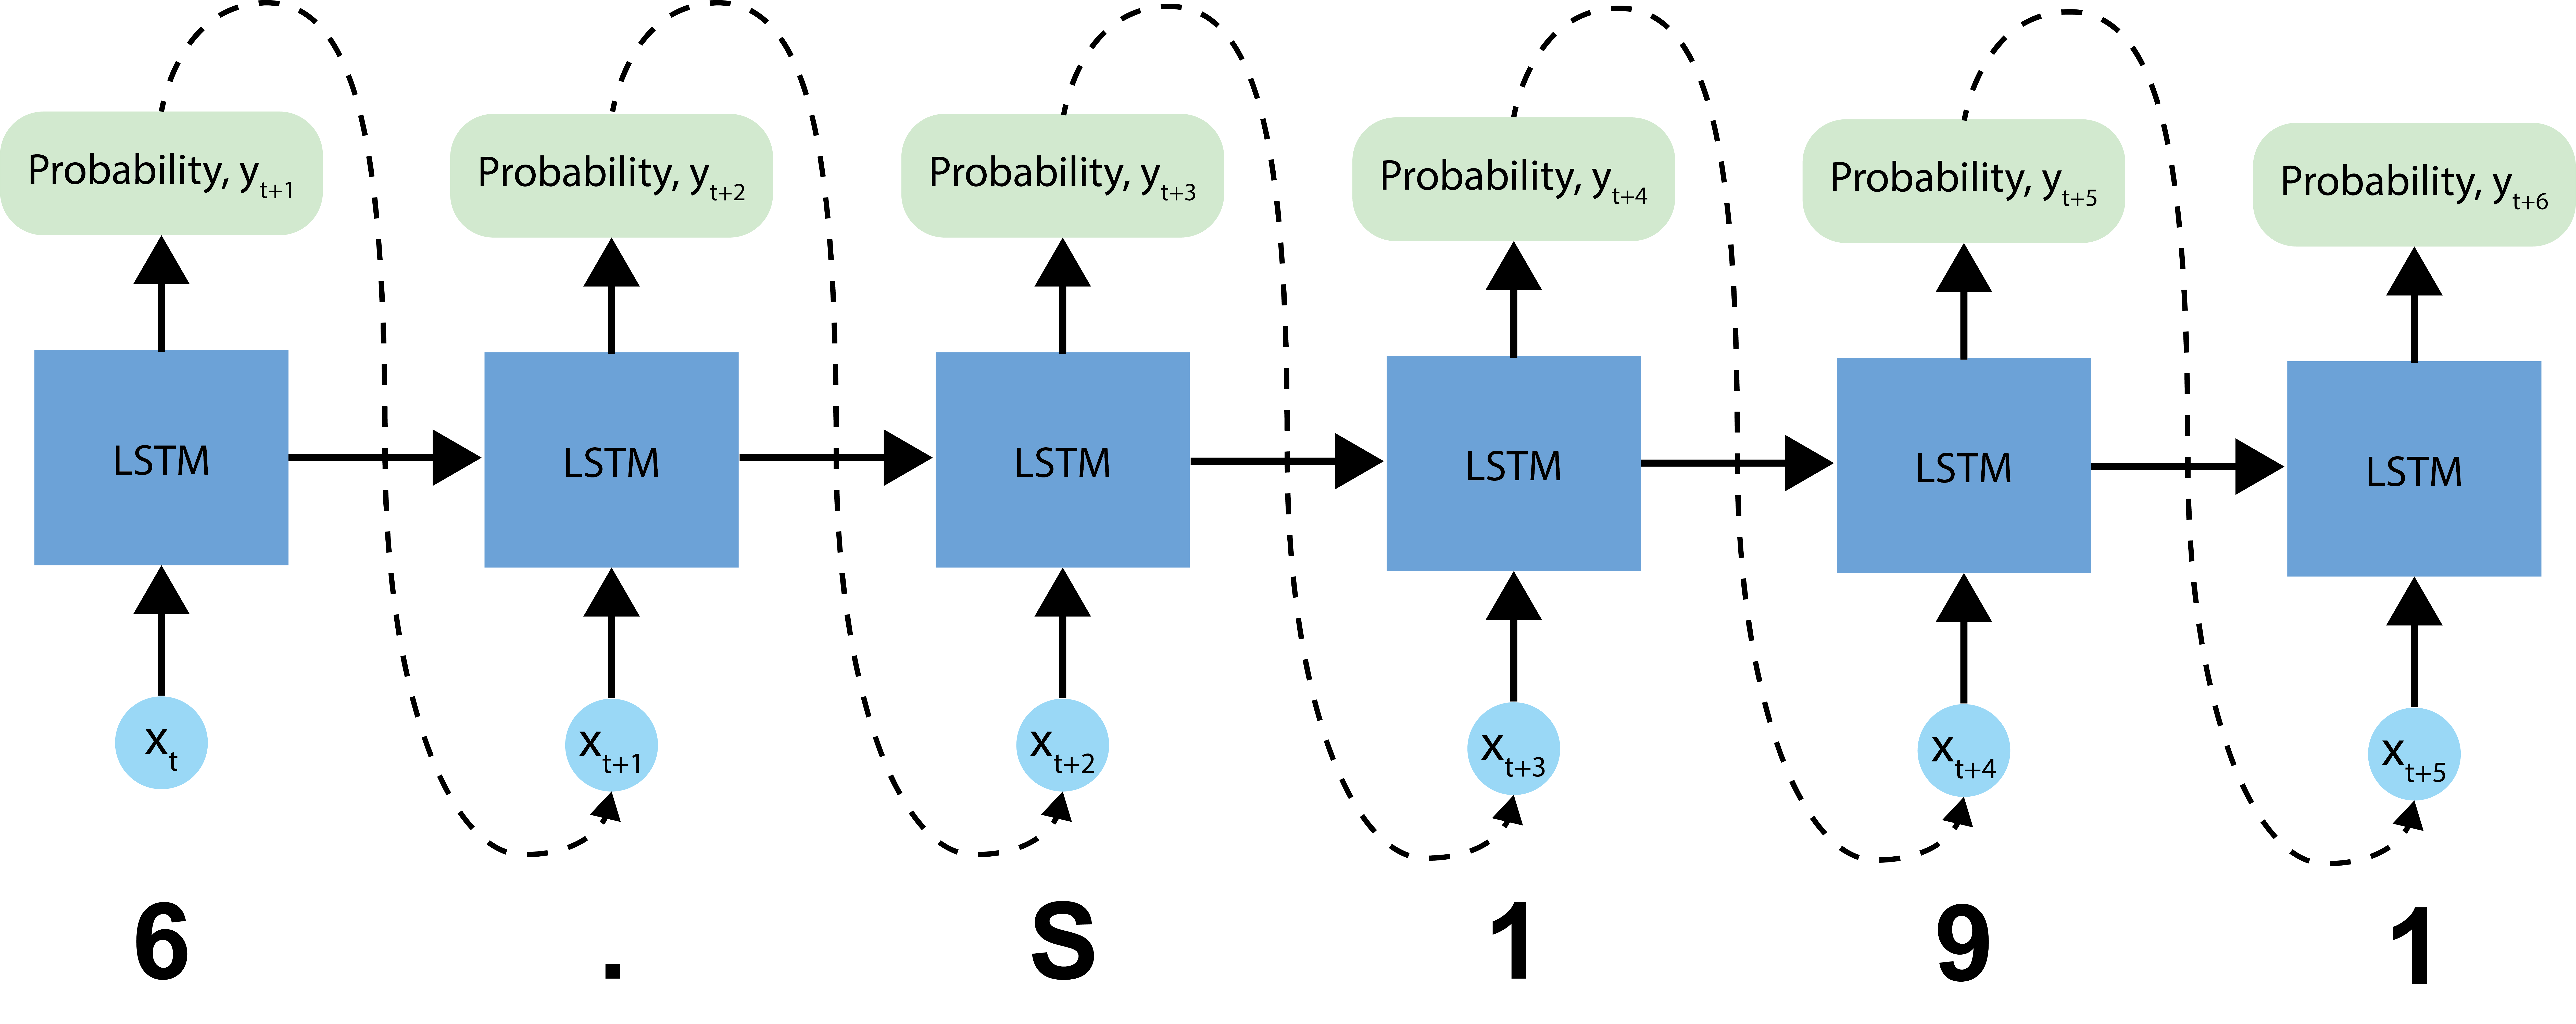

Complete and experiment with this code block (as well as some of the aspects of network definition and training!), and see how the model performs. How do songs generated after training with a small number of epochs compare to those generated after a longer duration of training?


In [25]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  input_eval = [char2idx[s] for s in start_string] # TODO

  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
 
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(idx2char[predicted_id]) # TODO 
   
    
  return (start_string + ''.join(text_generated))

In [26]:
generated_text = generate_text(model, start_string="X", generation_length=1000) 

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.89it/s]


# Play back the generated music!
We can now call a function to convert the ABC format text to an audio file, and then play that back to check out our generated music! Try training longer if the resulting song is not long enough, or re-generating the song!

In [28]:
### Play back generated songs ###
print(generated_text)
generated_songs = converter.parse(generated_text, )

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = song.show("midi")

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

Xdcc de|f3 edB|dBc c2A AGE Dorid:dc-jig-1
M:6/8
L:1/2
L:1/8
K:AA|BFA a2b|bea|agf|gegd|efdg|cefed|AFEFA ddfec dceg|edBg|cefd|edef Bfae|afAB|ABG AAB AGEE|D2D2|G3|]!

X:89
T:RerRacdJhroZ: id:dc-jig-13
M:C
L:1/4
L:1/4
T:Breay'suckan
Z: id:dc-jig-14
M:C
L:1/
D:A, Majorazatpjig-29
M:3/8
L:1/8
L:1/8
L:1/8
K:D Major
G2G|A2F EAFA AdBB|Aeed dBd|B3 F3|d2BA|GABf|dedB dABdB|AAB|AAFE DBAG E2AG|AAFF A2B cB A2:|!
gfag2 fed|A2:|!

X:83
T:Oupravearee or
E2EF|G2AB dfef daef geec|cA|fdB GBcB|decd|d2Bc|dAB2 cBd:|!
A|A2:|!
gABA|!

X:33
T:Tead:dc-reeldid:dc-chor
ghajor
E2Ac|cAG|]!
eef gfe|dedc|gaef dBAA|edfe|geddB A4B|ABGA|BGAF|EFDE|GFG E3G G2:|!
efgd|ced:|!

X:284
T:1/8
K:E Major2ala
Z:|!
L:1/8
K:A DcA|AG G2A|dedc BGG:|!
M:1/8
K:G DorieAGF AFEE EGA d2B,|EEAF2|BAA|dgg|dea2 efed|eAcf|geef dBB ABGA|!
aed|]!
GBA|BdB|ABdB|A2dc edBG|AE:|!
fefBe FAA Bcd|edae eff2|dgg dc|]!
EB,A,|GBde|fBcA d2BG|G2FGB,B,DDD E3:|!
DDEF DFED|A2FE|!

X:314
T:Da Tige CGChoug-58
M:Biafaporu
Z: id:dc-jig-562
M:6/8
L:1/8
L:1/8
K:A Did:dc-j

ABCHandlerException: no active default note length provided for note processing. tPrev: None, t: <music21.abcFormat.ABCNote 'X'>, tNext: <music21.abcFormat.ABCNote 'd'>

Happy listening:))
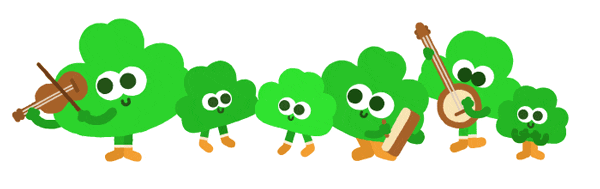